# DC IR analysis
This example shows how to configure EDB for DC IR analysis and load EDB into the HFSS 3D Layout UI for analysis and
postprocessing.

- Set up EDB:

    - Edit via padstack.
    - Assign SPICE model to components.
    - Create pin groups.
    - Create voltage and current sources.
    - Create SIwave DC analysis.
    - Create cutout.

- Import EDB into HFSS 3D Layout:

    - Analyze.
    - Get DC IR analysis results.

Keywords: **HFSS 3D Layout**, **DC IR**.

## Perform imports and define constants
Perform required imports.

In [1]:
import json
import os
import tempfile
import time

In [2]:
import ansys.aedt.core
from ansys.aedt.core.downloads import download_file
from pyedb import Edb

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

Download example board.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
aedb = download_file(source="edb/ANSYS-HSD_V1.aedb", destination=temp_folder.name)
download_file(
    source="spice", name="ferrite_bead_BLM15BX750SZ1.mod", destination=temp_folder.name
)

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpfzoji9j9.ansys\\spice\\ferrite_bead_BLM15BX750SZ1.mod'

## Create configuration file
This example uses a configuration file to set up the layout for analysis.
Initialize and create an empty dictionary to host all configurations.

In [5]:
cfg = dict()

Define model library paths.

In [6]:
cfg["general"] = {
    "s_parameter_library": os.path.join(temp_folder.name, "touchstone"),
    "spice_model_library": os.path.join(temp_folder.name, "spice"),
}

### Change via hole size and plating thickness

In [7]:
cfg["padstacks"] = {
    "definitions": [
        {"name": "v40h15-3", "hole_diameter": "0.2mm", "hole_plating_thickness": "25um"}
    ],
}

### Assign SPICE models

In [8]:
cfg["spice_models"] = [
    {
        "name": "ferrite_bead_BLM15BX750SZ1",  # Give a name to the SPICE Mode.
        "component_definition": "COIL-1008CS_V",  # Part name of the components
        "file_path": "ferrite_bead_BLM15BX750SZ1.mod",  # File name or full file path to the SPICE file.
        "sub_circuit_name": "BLM15BX750SZ1",
        "apply_to_all": True,  # If True, SPICE model is to be assigned to all components share the same part name.
        # If False, only assign SPICE model to components in "components".
        "components": [],
    }
]

### Create voltage source
Create a voltage source from a net.

In [9]:
cfg["sources"] = [
    {
        "name": "VSOURCE_5V",
        "reference_designator": "U4",
        "type": "voltage",
        "magnitude": 5,
        "positive_terminal": {"net": "5V"},
        "negative_terminal": {"net": "GND"},
    }
]

### Create current sources
Create current sources between the net and pin group.

In [10]:
cfg["pin_groups"] = [{"name": "J5_GND", "reference_designator": "J5", "net": "GND"}]

In [11]:
cfg["sources"].append(
    {
        "name": "J5_VCCR",
        "reference_designator": "J5",
        "type": "current",
        "magnitude": 0.5,
        "positive_terminal": {"net": "SFPA_VCCR"},
        "negative_terminal": {
            "pin_group": "J5_GND"  # Defined in "pin_groups" section.
        },
    }
)
cfg["sources"].append(
    {
        "name": "J5_VCCT",
        "reference_designator": "J5",
        "type": "current",
        "magnitude": 0.5,
        "positive_terminal": {"net": "SFPA_VCCT"},
        "negative_terminal": {
            "pin_group": "J5_GND"  # Defined in "pin_groups" section.
        },
    }
)

### Create SIwave DC analysis

In [12]:
cfg["setups"] = [{"name": "siwave_dc", "type": "siwave_dc", "dc_slider_position": 0}]

### Define cutout

In [13]:
cfg["operations"] = {
    "cutout": {
        "signal_list": ["SFPA_VCCR", "SFPA_VCCT", "5V"],
        "reference_list": ["GND"],
        "extent_type": "ConvexHull",
        "expansion_size": 0.002,
        "use_round_corner": False,
        "output_aedb_path": "",
        "open_cutout_at_end": True,
        "use_pyaedt_cutout": True,
        "number_of_threads": 4,
        "use_pyaedt_extent_computing": True,
        "extent_defeature": 0,
        "remove_single_pin_components": False,
        "custom_extent": "",
        "custom_extent_units": "mm",
        "include_partial_instances": False,
        "keep_voids": True,
        "check_terminals": False,
        "include_pingroups": False,
        "expansion_factor": 0,
        "maximum_iterations": 10,
        "preserve_components_with_model": False,
        "simple_pad_check": True,
        "keep_lines_as_path": False,
    }
}

### Save configuration as a JSON file

In [14]:
pi_json = os.path.join(temp_folder.name, "pi.json")
with open(pi_json, "w") as f:
    json.dump(cfg, f, indent=4, ensure_ascii=False)

## Load configuration into EDB

Load the configuration from the JSON file into EDB.

In [15]:
edbapp = Edb(aedb, edbversion=AEDT_VERSION)
edbapp.configuration.load(config_file=pi_json)
edbapp.configuration.run()

PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.31.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database ANSYS-HSD_V1.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: Cutout Multithread started.


PyAEDT INFO: Net clean up Elapsed time: 0m 2sec


PyAEDT INFO: Extent Creation Elapsed time: 0m 0sec


PyAEDT INFO: 13 Padstack Instances deleted. Elapsed time: 0m 1sec


PyAEDT INFO: 6 Primitives deleted. Elapsed time: 0m 3sec


PyAEDT INFO: 168 components deleted


PyAEDT INFO: Cutout completed. Elapsed time: 0m 6sec


True

PyAEDT INFO: Nets Point Generation time 1.881 seconds


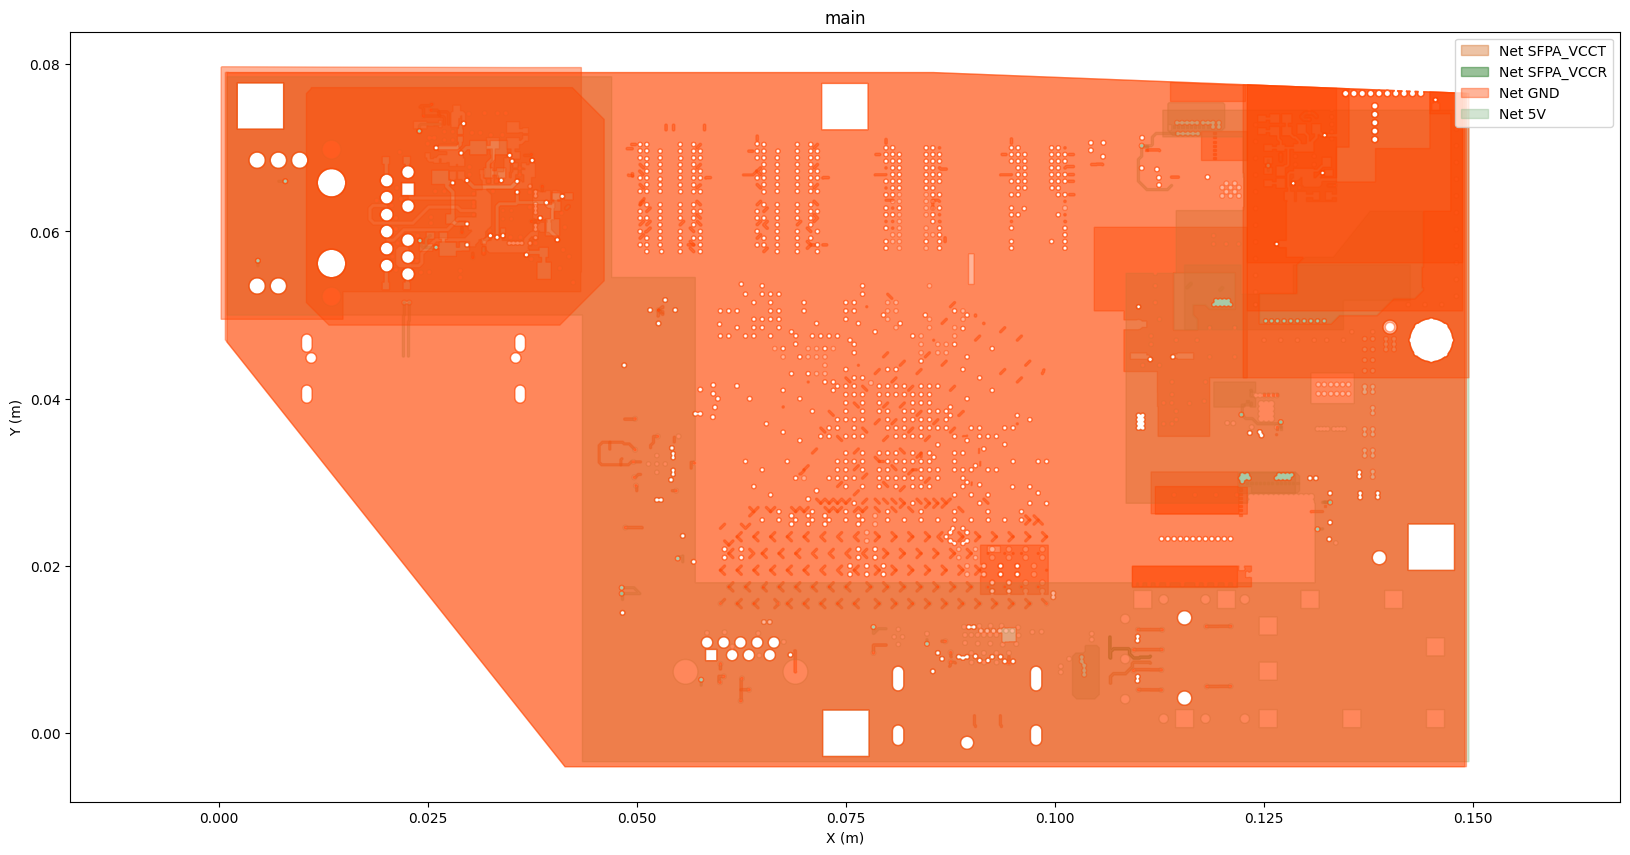

<module 'matplotlib.pyplot' from 'C:\\actions-runner\\_work\\pyaedt-examples\\pyaedt-examples\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [16]:
# # Load configuration into EDB
edbapp.nets.plot(None, None, color_by_net=True)

## Save and close EDB

In [17]:
edbapp.save()
edbapp.close()

True

The configured EDB file is saved in the temporary folder.

In [18]:
print(temp_folder.name)

C:\Users\ansys\AppData\Local\Temp\tmpfzoji9j9.ansys


## Analyze DCIR with SIwave

The HFSS 3D Layout interface to SIwave is used to open the EDB and run the DCIR analysis
using SIwave

### Load EDB into HFSS 3D Layout.

In [19]:
siw = ansys.aedt.core.Hfss3dLayout(
    aedb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_080f02f6-e055-4d22-a3fb-4bc577942e47.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 59543


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 5812.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpfzoji9j9.ansys\edb/ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


### Analyze

In [20]:
siw.analyze(cores=NUM_CORES)

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 59.0s


True

### Get DC IR results

In [21]:
siw.get_dcir_element_data_current_source("siwave_dc")

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpfzoji9j9.ansys/edb/ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpfzoji9j9.ansys/edb/ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03125476837158203


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: EDB loaded.


PyAEDT INFO: Layers loaded.


PyAEDT INFO: Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


Voltage
J5_VCCT  4.884437
J5_VCCR  4.884558

## Release AEDT

In [22]:
siw.save_project()
siw.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [23]:
temp_folder.cleanup()